*Please type the ticker of the stock that you want to predict, in the variable stock_symbl. If you use stock ticker other than [AAPL, MSFT, CMG, AMZN], then the model would work fine, the only problem would be that the financial statement data prior to 2015 would not be used. Since we have used the Alpha Vantage API, it only provides free quaterly financial staterment of five years. Thats why we have to attach an additional data._stockTicker.csv file to use data before 2015.*

$\textbf{Warning :}$  *ONLY PLACE TO ENTER INPUTE VALUES IN THIS FILE IS IN THE INPUT SECTION, WHERE YOU JUST HAVE TO ENTER THE STOCK TICKER NAME AND THE DATA FILE(DATA FILE IS OPTIONAL IF YOU DONT WANT DATA PRIOR 2015). SECONDLY IN "GETTING DATA AND PREPROCESSING SECTION". THERE YOU CAN TWEAK THE PARAMETERS OF "download_and_transform" FUNCTION TO GET DESIRED DATA.*

## $\textbf{Input}$

In [ ]:
stock_symbl = 'AAPL'
data_file = 'data_aapl.csv'

## $\textbf{Imports}$

In [ ]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from datetime import date, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
 
from sklearn.metrics import mean_squared_error
plt.style.use('ggplot')
 
!pip install alpha_vantage
import requests

     |████████████████████████████████| 1.3MB 12.7MB/s 
     |████████████████████████████████| 143kB 21.1MB/s 
     |████████████████████████████████| 296kB 35.8MB/s 


## $\textbf{Downloading fundamental Data into dataframe}$

*In this section we will download the financial data from the Alpha Vantage API.  Please vist the Alpha vantage documentation for clear understanding of how their API works.*

In [ ]:

API_URL = "https://www.alphavantage.co/query" 


data_earnings = { 
    "function": 'EARNINGS', 
    "symbol": stock_symbl,
    "outputsize" : "compact",
    "datatype": "json", 
    "apikey": '0J60AGKUN42KGVXB'} 

response_earnings = requests.get(API_URL, data_earnings) 
response_earnings_json = response_earnings.json()

earnings_df = pd.DataFrame(response_earnings_json['quarterlyEarnings'])
earnings_df.set_index('fiscalDateEnding',inplace=True)


eps = earnings_df[['reportedEPS']]
eps


data_inc = { 
    "function": 'INCOME_STATEMENT', 
    "symbol": stock_symbl,
    "outputsize" : "full",
    "datatype": "pandas", 
    "apikey": '0J60AGKUN42KGVXB'} 

response_inc = requests.get(API_URL, data_inc) 
response_inc_json = response_inc.json()


inc_dic = {
            'fiscalDateEnding' : [],
            'operatingIncome' : [],
            'grossProfit': [],
            'totalRevenue' :[]
          }

for i in range(len(response_inc_json['quarterlyReports'])):
  inc_dic['fiscalDateEnding'].append(response_inc_json['quarterlyReports'][i]['fiscalDateEnding'])
  inc_dic['operatingIncome'].append(10e-6*float(response_inc_json['quarterlyReports'][i]['operatingIncome']))
  inc_dic['grossProfit'].append(10e-6*float(response_inc_json['quarterlyReports'][i]['grossProfit']))
  inc_dic['totalRevenue'].append(10e-6*float(response_inc_json['quarterlyReports'][i]['totalRevenue']))

income_stmt = pd.DataFrame(inc_dic)
income_stmt.set_index('fiscalDateEnding', inplace=True)

new_inc = pd.read_csv(data_file)
new_inc.dropna(axis=1, inplace=True)

new_inc.columns = ['fiscalDateEnding', 'totalRevenue', 'grossProfit', 'operatingIncome']
new_inc.set_index('fiscalDateEnding',inplace=True)


income_stmt = income_stmt.append(new_inc)
#income_stmt


In [ ]:
income_stmt

,operatingIncome,grossProfit,totalRevenue
fiscalDateEnding,,,
2021-03-31,275030.0,380790.0,889140.0
2020-12-31,335340.0,443280.0,1108010.0
2020-09-30,147750.0,246890.0,640640.0
2020-06-30,130910.0,226800.0,589880.0
2020-03-31,128530.0,223700.0,575560.0
2019-12-31,255690.0,352170.0,910340.0
2019-09-30,156250.0,243130.0,632300.0
2019-06-30,115440.0,202270.0,529430.0
2019-03-31,134150.0,218210.0,580150.0


## $\textbf{Defining fucntions}$

*In this section we define the functions to calculate different technical indicator that we have used as features in our code. These function clearly defines the methods and what parameters to put to get the indicators. For example, RSI can be calculated directly using the price data and period as parameter.*



In [ ]:
def calculate_rsi(close_price_df, period=14):
  '''
  This function calculated the Relative Strength Index (RSI) from the prices. The defualt period to calculate RSI
  has been set to 14. 
  
  Parameters:

  close_price_df: It should be a dataframe with only one column that contains the close prices of the stock. This dataframe
                  must contain the date as index. Because this function when used inside other functions, helps in joining dataframe
                  on date index (datetime object). Hence if the index is not date then it would create problems while joining thid with other datafrae.
  period :(use int) This is the period using which RSI is calculated. If any other data type is used, it will be converted to int
  '''
  period = int(period)

  rsi_dummy = close_price_df.copy(True)
  rsi_dummy.dropna(axis=0, inplace=True)
  rsi_dummy['Change'] = rsi_dummy.iloc[:,[0]] - rsi_dummy.iloc[:,[0]].shift(1)
  rsi_dummy['Gain'] = np.where(rsi_dummy['Change']>0,rsi_dummy['Change'],0)
  rsi_dummy['Loss'] = np.where(rsi_dummy['Change']<0,-rsi_dummy['Change'],0)
  avg_gain = []
  avg_loss = []

  for i in range(len(rsi_dummy)):
    if (i<(period-1)):
      avg_gain.append(np.NaN)
      avg_loss.append(np.NaN)
    elif i==(period-1):
      avg_gain.append((rsi_dummy['Gain'][0:period].values.sum())/period)
      avg_loss.append((rsi_dummy['Loss'][0:period].values.sum())/period)
    else:
      avg_gain.append( (avg_gain[i-1]*(period-1) + rsi_dummy['Gain'][i] )/period   )
      avg_loss.append( (avg_loss[i-1]*(period-1) + rsi_dummy['Loss'][i] )/period   )

  rsi_dummy['Avg_gain'] = np.array(avg_gain)
  rsi_dummy['Avg_loss'] = np.array(avg_loss)
  rsi_dummy['RS'] = rsi_dummy['Avg_gain'] / rsi_dummy['Avg_loss']
  rsi_dummy['RSI'] = np.where(rsi_dummy['Avg_loss']==0,100, 100-(100/(1+rsi_dummy['RS'])) )
  rsi_dummy = rsi_dummy.dropna(axis=0)
  return rsi_dummy[['RSI']]



def calculate_MACD(data_df,fast_period=12 , slow_period=26, signal_period=9 ):
  '''
  This function calculates the the four colums, macd_fast, macd_sloe, macd, and macd_signal. For clearer understanding read how macd is calculated.
  The parameters are simply the periods of the fast, slow, and signal exponential averages.

  The default values for fast_period, slow_period and signal_period are 12, 26 and 9 respectively.

  The data_df should be a dataframe with index as date time object and it should only contain one column for the closing price of the stock, on which
  the macd moving averages will be calculated. If you want to calculate the same averages and signal on opening prices, or high, or low, then you can
  replace the closing price, column with that.
  '''

  fast_period = int(fast_period)
  slow_period = int(slow_period)
  signal_period = int(signal_period)

  macd = data_df.iloc[:,[0]].copy(True)
  macd = macd.dropna(axis=0)
  macd['macd_fast'] = macd.iloc[:,[0]].ewm(span=fast_period, min_periods=fast_period).mean()
  macd['macd_slow'] = macd.iloc[:,[0]].ewm(span=slow_period, min_periods=slow_period).mean()
  macd['MACD'] = macd['macd_fast'] - macd['macd_slow']
  macd['macd_signal'] = macd['MACD'].ewm(span=signal_period, min_periods=signal_period).mean()
  macd = macd.dropna(axis=0)
  
  return macd[['macd_fast', 'macd_slow', 'MACD', 'macd_signal']]



def calculate_ATR(data_df, atr_period=14):
  '''
  ATR calculated the Average True range. atr_period is the period according to which the moving average is calculated.
  The default is 14.

  data_df should be a dataframe with index as a datetime object so that you can easily join this later with your data.
  data_df should contain the following columns, 'High', 'Low', 'Adj Close', they can be in any order.
  '''

  atr_period = int(atr_period)

  atr_df = data_df.copy(True)
  atr_df = atr_df.dropna(axis=0)

  atr_df['H-L'] = abs(atr_df['High'] - atr_df['Low'])
  atr_df['H-Cp'] = abs(atr_df['High'] - atr_df['Adj Close'].shift(1))
  atr_df['L-Cp'] = abs(atr_df['Low'] - atr_df['Adj Close'].shift(1))
  atr_df['TR']  = atr_df[['H-L', 'H-Cp', 'L-Cp']].max(axis=1, skipna=False)
  atr_df['ATR'] = atr_df['TR'].rolling(atr_period).mean()
  atr_df = atr_df.dropna(axis=0)

  return atr_df[['ATR']]



def calculate_OBV(data_df):
  '''
  This function calculated the On-Balace Volume(OBV) from the given data.
  data_df must be a dataframe with these two columns, 'Adj Close' and 'Volume'

  '''
  obv_df = data_df.copy(True)
  obv_df = obv_df.dropna(axis=0)
  obv_df['rtn'] = obv_df['Adj Close'].pct_change()
  obv_df['Adj_volume'] = np.where(obv_df['rtn']>0, obv_df['Volume'], -obv_df['Volume'])
  obv_df['Adj_volume'][0] = 0
  obv_df['OBV'] = obv_df['Adj_volume'].cumsum()
  obv_df = obv_df.dropna(axis=0)

  return obv_df[['OBV']]



def calculate_Bollinger_Band(data_df, bb_sma_period=20):
  '''
  This function calculate the bollinger band for th given data.

  data_df must be a dataframe with only close price as the column 
    (Should contain only one column, The function takes the first column 
    as the close 
    prices). And the index of the data_df should be a datetime object for further convenienceto join the dataframe.

  bb_sma_period is the simple moving average period to calculate the bollinger band. 
  '''
  bb_sma_period = int(bb_sma_period)
  bb_df = data_df.copy(True)
  bb_df = bb_df.dropna(axis=0)

  bb_df['MA'] = bb_df.iloc[:,[0]].rolling(bb_sma_period).mean()
  bb_df['BB_upper'] = bb_df['MA'] + 2*bb_df['MA'].rolling(bb_sma_period).std()
  bb_df['BB_lower'] = bb_df['MA'] - 2*bb_df['MA'].rolling(bb_sma_period).std()
  bb_df = bb_df.dropna(axis=0)

  return bb_df[['BB_upper', 'BB_lower']]




def calculate_ADX(data_df, adx_period=14):
  '''
  This function calculated the Average Directional index (ADX). 

  data_df : Must be a dataframe with columns, 'High', 'Low', and 'Adj Close'. Index must be a datetime object (date)

  '''
  adx_period = int(adx_period) 
  adx_df = data_df.copy(True)
  adx_df = adx_df.dropna(axis=0)

  adx_df['H-L'] = abs(adx_df['High'] - adx_df['Low'])
  adx_df['H-Cp'] = abs(adx_df['High'] - adx_df['Adj Close'].shift(1))
  adx_df['L-Cp'] = abs(adx_df['Low'] - adx_df['Adj Close'].shift(1))
  adx_df['TR']  = adx_df[['H-L', 'H-Cp', 'L-Cp']].max(axis=1, skipna=False)
  adx_df['+DM_1'] = np.where((adx_df['High']-adx_df['High'].shift(1)) >( adx_df['Low'].shift(1) -adx_df['Low']), adx_df['High']-adx_df['High'].shift(1), 0 )
  adx_df['+DM_1'] = np.where(adx_df['+DM_1']<0, 0 ,adx_df['+DM_1'])
  adx_df['-DM_1'] = np.where((adx_df['Low'].shift(1)-adx_df['Low'])>(adx_df['High']-adx_df['High'].shift(1)),adx_df['Low'].shift(1)-adx_df['Low'],0)
  adx_df['-DM_1'] = np.where(adx_df['-DM_1'] <0, 0,adx_df['-DM_1'])
  adx_df['+DM_1'][0] = np.NaN
  adx_df['-DM_1'][0] = np.NaN

  TR_N = []
  DM_plus_N = []
  DM_minus_N = []

  for i in range(len(adx_df)):
    if i < (adx_period):
      TR_N.append(np.NaN)
      DM_plus_N.append(np.NaN)
      DM_minus_N.append(np.NaN)
    elif i == (adx_period):
      TR_N.append(adx_df['TR'][:adx_period+1].sum())
      DM_plus_N.append(adx_df['+DM_1'][:adx_period+1].sum())
      DM_minus_N.append(adx_df['-DM_1'][:adx_period+1].sum())
    else:
      TR_N.append(TR_N[i-1]*((adx_period-1)/adx_period) + adx_df['TR'][i] )
      DM_plus_N.append(DM_plus_N[i-1]*((adx_period-1)/adx_period) + adx_df['+DM_1'][i] )
      DM_minus_N.append(DM_minus_N[i-1]*((adx_period-1)/adx_period) + adx_df['-DM_1'][i] )

  adx_df['TR_N'] = np.array(TR_N)
  adx_df['+DM_N'] = np.array(DM_plus_N)
  adx_df['-DM_N'] = np.array(DM_minus_N)

  adx_df['+DI_N'] = 100* adx_df['+DM_N'] / adx_df['TR_N']
  adx_df['-DI_N'] = 100* adx_df['-DM_N'] / adx_df['TR_N']
  adx_df['Diff_DI_N'] = abs(adx_df['+DI_N'] - adx_df['-DI_N'])
  adx_df['Sum_DI_N'] = (adx_df['+DI_N'] + adx_df['-DI_N'])
  adx_df['DX'] = 100* adx_df['Diff_DI_N'] / adx_df['Sum_DI_N']

  ADX = []

  for i in range(len(adx_df)):
    if i <(2*adx_period-1):
      ADX.append(np.NaN)
    elif i==(2*adx_period-1):
      ADX.append(np.mean(adx_df['DX'][i-adx_period+1 : i+1]))
    else:
      ADX.append( ((adx_period-1)*ADX[i-1] + adx_df['DX'][i])/adx_period )


  adx_df['ADX'] = np.array(ADX)
  #adx_df = adx_df.dropna(axis=0)

  return adx_df['ADX']





  



In [ ]:


def download_and_transform_data(stock_ticker,
                                predict_close=True,                                
                                
                                look_back_period_close = 0,
                                look_back_period_open =0 ,
                                sma_freq_close = [],
                                sma_freq_open = [],

                                add_eps = False, eps_df=None,
                                add_income_stmt = False ,income_stmt_df =None,
                                
                                add_RSI = True, rsi_period=14,
                                add_MACD = True, macd_fst_slw_sig = [12,26,9],
                                add_ATR = True, atr_period =14,
                                add_OBV = True,
                                add_ADX = True, adx_period = 14,
                                add_BBand = True, bb_period = 20,
                                
                                ):
  '''
  This function downloads the data from yahoo and then convert that data into matrix form. First of all it converts the data so that the 
  the target value, i.e the close price is predicted on the basis of the previous day's open high low volumne and then it uses the lookback period
  to create the columns of the lookback. It then uses the list sma_freq to calculate the simple moving average columns accordint to the given freq
  LAstly it splits the data into train and test set for the model traingn and testing.
  '''
  
  start = date(2008,1,1)
  
  data_df = web.DataReader(name=stock_ticker, data_source='yahoo', start=start, end=date.today())

  
  if predict_close==True:
    predictor = 'Adj Close'
    not_predictor = 'Open'
  else:
    predictor = 'Open'
    not_predictor = 'Adj Close'


  dummy_ = data_df.drop('Close',axis=1,)[['High', 'Low', not_predictor, 'Volume']]
  dummy_ = dummy_.shift(1)
  dummy_[predictor] = data_df[predictor]
  dummy_ = dummy_[1:]

  for i in range(look_back_period_close):
    dummy_['Close_t-{}'.format(i+1)] = dummy_['Adj Close'].shift(i+1)

  for i in range(look_back_period_open):
    dummy_['Open_t-{}'.format(i+1)] = dummy_['Open'].shift(i+1)

  for frq in sma_freq_close:
    dummy_['SMA_Close_{}'.format(frq)] = dummy_['Adj Close'].rolling(frq).mean()

  for frq in sma_freq_open:
    dummy_['SMA_Open_{}'.format(frq)] = dummy_['Open'].rolling(frq).mean()

  if add_eps==True:
    dummy_ = dummy_.join(eps_df, how='outer')
    dummy_['reportedEPS'].fillna(method='ffill', inplace=True)

  if add_income_stmt==True:
    dum = dummy_.join(income_stmt_df, how='outer')
    dum['operatingIncome'].fillna(method='ffill', inplace=True)
    dum['grossProfit'].fillna(method='ffill', inplace=True)
    dum['totalRevenue'].fillna(method='ffill', inplace=True)

  if add_RSI==True:
    dum = dum.join(calculate_rsi(dum[['Adj Close']],
                                 int(rsi_period)
                                 ))

  if add_MACD==True:
    dum = dum.join(calculate_MACD(dum[['Adj Close']],
                                  int(macd_fst_slw_sig[0]),
                                  int(macd_fst_slw_sig[1]),
                                  int(macd_fst_slw_sig[2]),
                                  ))
    
  if add_ATR==True:
    dum = dum.join(calculate_ATR(dum[['High', 'Low', 'Adj Close']], int(atr_period)))

  if add_OBV==True:
    dum = dum.join(calculate_OBV(dum[['Adj Close', 'Volume']]))

  if add_BBand==True:
    dum = dum.join(calculate_Bollinger_Band(dum[['Adj Close']],
                                            int(bb_period)
                                            ))

  if add_ADX==True:
    dum = dum.join(calculate_ADX(dum[['High', 'Low', 'Adj Close', 'Volume']],int(adx_period)))
  
  dummy_ = dum.dropna(axis=0)

  return data_df, dummy_

###################################################################################

def create_train_test_split(data,predict_close =True,
                            train_size =0.75, 
                            val_size =0.15, 
                            print_rslt=False 
                            ):

  test_size = 1 - train_size - val_size

  assert all( x >=0 for x in [train_size, val_size, test_size]) 
  assert all( x <=1 for x in [train_size, val_size, test_size]) 
  assert (train_size + val_size + test_size) == 1

  if predict_close==True:
    predictor = 'Adj Close'
    not_predictor = 'Open'
  else:
    predictor = 'Open'
    not_predictor = 'Adj Close'
    

  train_split = data[:int(train_size*len(data))]
  val_split   = data[int(train_size*len(data)):int((train_size + val_size)*len(data))]
  test_split =  data[int((train_size + val_size)*len(data)):]

  train_x = train_split.drop(predictor, axis=1)
  train_y = train_split[[predictor]]

  val_x = val_split.drop(predictor, axis=1)
  val_y = val_split[[predictor]]

  test_x = test_split.drop(predictor, axis=1)
  test_y = test_split[[predictor]]

  if print_rslt ==True:
    print('x train shape:', train_x.shape)
    print('y train shape:', train_y.shape)
    print('x val shape:', val_x.shape)
    print('y val shape:', val_y.shape)
    print('x test shape:', test_x.shape)
    print('y test shape:', test_y.shape)

  return [train_x, train_y, val_x, val_y, test_x, test_y]

  

## $\textbf{Getting Data and preprocessing}$

*Here we used the above defined function to download and transform data in desired way. Go through the parameters and choose as per you want. We describe here how the paramter works in this funciton*

Function : download_and_transform_data

predict_close : Choose if you want to predict today's close price or tomorrows open. Default Ture (predict close)

look_back_period_close : How many days of previous close price to consider in features

look_back_period_open : How many days of previous open price to consider in features

sma_freq_close : a list of all frq of sma of close you want to add in features 

sma_freq_open : a list of all frq of sma of open you want to add in features 

add_eps / add_icome_stmt : whether you want these as features in model

Rest 'add' parameter is added for all other techinical indicators and they are self explanatory.


In [ ]:
stock_orig , stock_data= download_and_transform_data(stock_symbl,                                                   
                                                     
                                                     look_back_period_close=0, 
                                                     sma_freq_close=[20,50,80,100,200],
                                                     predict_close=True,
                                                     add_income_stmt=True, income_stmt_df =income_stmt,                                                      
                                                    
                                                     )


In [ ]:
# plt.figure(figsize= (16,8))
# plt.plot(stock_orig['Adj Close'])
# plt.xlabel('Time', fontsize=16)
# plt.ylabel('Stock Price', fontsize=16)
# plt.title('{} stock price'.format(stock_symbl), fontsize=18)

This function 'create_train_test_split' is defined above and it splits data in as follows : x_train, y_train, x_val, y_val, x_test, y_test , according to the parameters given

In [ ]:
tt = create_train_test_split(stock_data)

In [ ]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(tt[0])
y_train = tt[1]

X_val = scaler.transform(tt[2])
y_val = tt[3]

X_test  = scaler.transform(tt[4])
y_test  = tt[5]

print('Scaled X_train Shape :', X_train.shape)
print('Scaled y_train Shape :', y_train.shape)
print('\n')
print('Scaled X_val Shape :', X_val.shape)
print('Scaled y_val Shape :', y_val.shape)
print('\n')
print('Scaled X_test Shape :', X_test.shape)
print('Scaled y_test Shape :', y_test.shape)


Scaled X_train Shape : (1815, 22)
Scaled y_train Shape : (1815, 1)


Scaled X_val Shape : (363, 22)
Scaled y_val Shape : (363, 1)


Scaled X_test Shape : (242, 22)
Scaled y_test Shape : (242, 1)


## $\textbf{SVR}$

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svr_reg = SVR()
params = {'kernel' :['linear', 'rbf'], 'gamma':[0.001,0.005,0.01,0.05,], 'C':[1,10,50,100]}
grid_svr = GridSearchCV(svr_reg,params,scoring='neg_mean_squared_error',cv=5, verbose=4)
grid_svr.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] C=1, gamma=0.001, kernel=linear .................................
[CV] .... C=1, gamma=0.001, kernel=linear, score=-0.046, total=   0.1s
[CV] C=1, gamma=0.001, kernel=linear .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .... C=1, gamma=0.001, kernel=linear, score=-0.040, total=   0.2s
[CV] C=1, gamma=0.001, kernel=linear .................................
[CV] .... C=1, gamma=0.001, kernel=linear, score=-0.076, total=   0.2s
[CV] C=1, gamma=0.001, kernel=linear .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


[CV] .... C=1, gamma=0.001, kernel=linear, score=-0.052, total=   0.2s
[CV] C=1, gamma=0.001, kernel=linear .................................
[CV] .... C=1, gamma=0.001, kernel=linear, score=-0.734, total=   0.1s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ...... C=1, gamma=0.001, kernel=rbf, score=-71.202, total=   0.2s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ...... C=1, gamma=0.001, kernel=rbf, score=-66.945, total=   0.2s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ...... C=1, gamma=0.001, kernel=rbf, score=-19.431, total=   0.2s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ...... C=1, gamma=0.001, kernel=rbf, score=-29.950, total=   0.2s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..... C=1, gamma=0.001, kernel=rbf, score=-388.573, total=   0.2s
[CV] C=1, gamma=0.005, kernel=linear .................................
[CV] .

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 50, 100],
                         'gamma': [0.001, 0.005, 0.01, 0.05],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=4)

In [ ]:
grid_svr.best_params_


{'C': 100, 'gamma': 0.001, 'kernel': 'linear'}

In [ ]:
y_predic_svr = grid_svr.predict(X_val)
print('Train MSE :', mean_squared_error(np.ravel(y_train), grid_svr.predict(X_train)))
print('Val MSE :', mean_squared_error(np.ravel(y_val), y_predic_svr))
print('Test MSE :', mean_squared_error(np.ravel(y_test),grid_svr.predict(X_test)))

Train MSE : 0.04834266670368254
Val MSE : 0.7686484084914867
Test MSE : 2.801054237883902


In [ ]:
np.ravel(grid_svr.best_estimator_.coef_)

array([-8.29491225e+00, -5.67123564e-01, -8.95450109e+00,  2.08688211e-01,
        1.59058740e+01, -1.11505320e+01, -4.97628708e+00, -9.78061201e-02,
        9.43380014e-02, -3.76799309e-01,  8.38075775e-01, -5.42556059e-01,
        1.28279316e+00,  1.62996240e+01,  1.36682568e+01,  2.85899219e+01,
       -2.43897201e+01,  7.04053843e-01,  1.13591849e-02,  1.54283396e+01,
        1.55980057e+01, -1.70799850e-01])

Text(0.5, 1.0, 'Feature Importance AAPL')

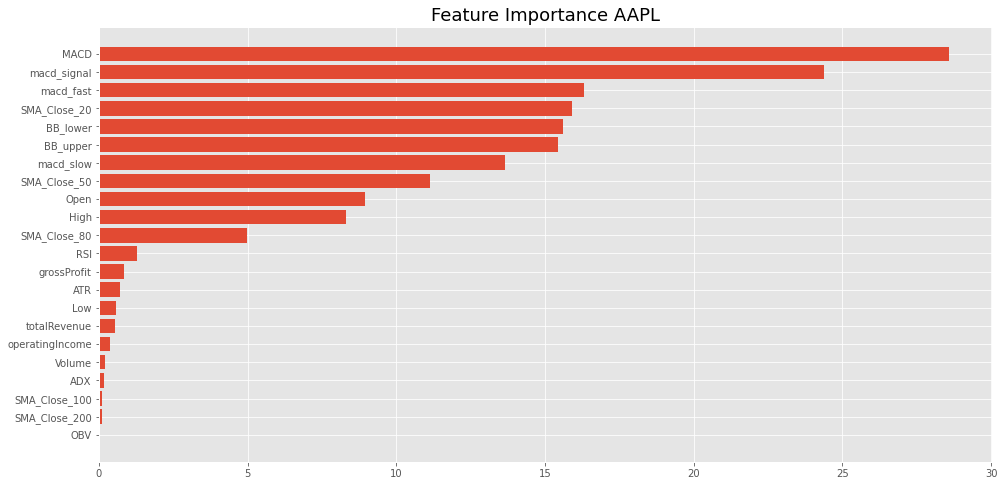

In [ ]:
zip_df = pd.DataFrame( zip(tt[0].columns.tolist(), np.ravel(grid_svr.best_estimator_.coef_)), columns=['Name', 'Coef'])
zip_df['Abs_coef'] = abs(zip_df['Coef'])

plt.figure(figsize=(16,8))
plt.barh(zip_df.sort_values('Abs_coef')['Name'], zip_df.sort_values('Abs_coef')['Abs_coef']         )
plt.title('Feature Importance {}'.format(stock_symbl), fontsize=18)


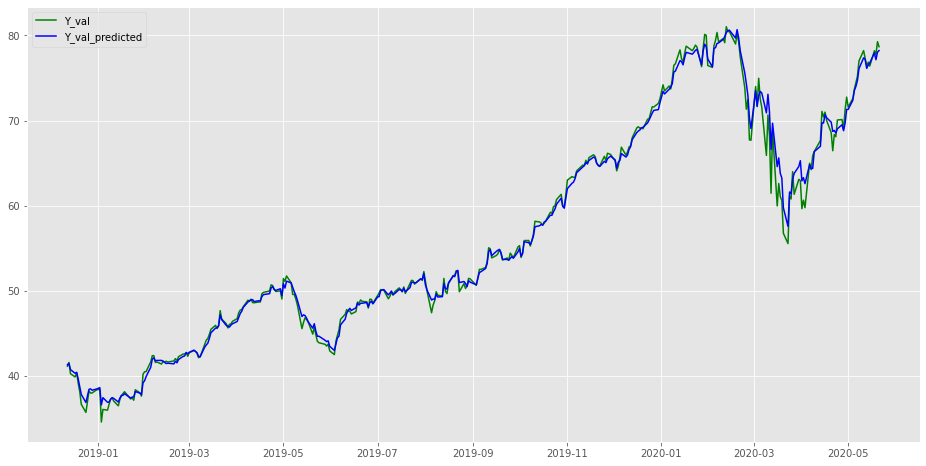

In [ ]:
y_rand_svr = y_val.copy(True)
y_rand_svr['y_val_predicted'] = y_predic_svr
y_rand_svr.rename(columns={'Adj Close' : 'y_val'}, inplace=True)

plt.figure(figsize=(16,8))
plt.plot(y_rand_svr.iloc[:,0], 'g-', label='Y_val')
plt.plot(y_rand_svr.iloc[:,1], 'b-', label='Y_val_predicted')
plt.legend()

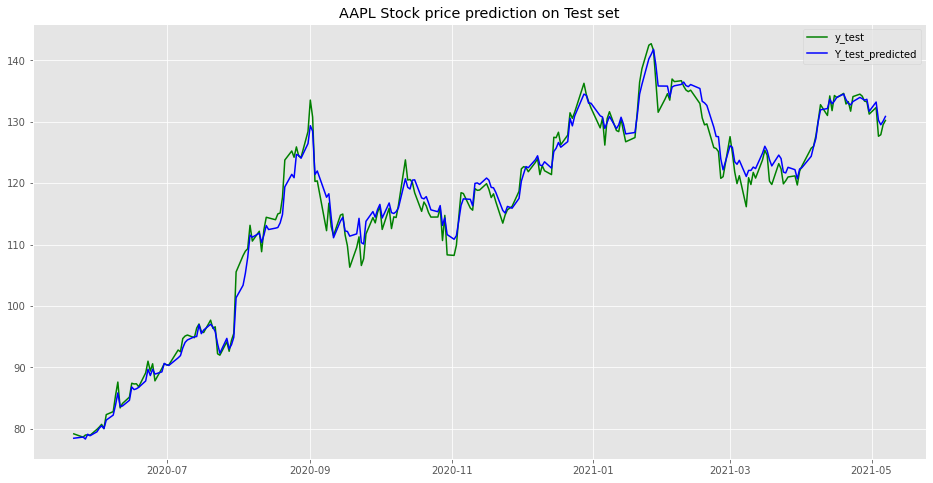

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_test, 'g-', label='y_test')
plt.plot(pd.DataFrame(grid_svr.predict(X_test), index=y_test.index), 'b-', label='Y_test_predicted')
plt.title('{} Stock price prediction on Test set'.format(stock_symbl))
plt.legend()

## $\textbf{LGBM}$

In [ ]:
from lightgbm import LGBMRegressor

model_lgbm = LGBMRegressor(n_estimators=100000,
                           learning_rate=0.01,
                           max_depth=15,
                           class_weight = 'balanced',


                           )

model_lgbm.fit(X_train, np.ravel(y_train), categorical_feature=[9,10,11])



/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [9, 10, 11]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


LGBMRegressor(boosting_type='gbdt', class_weight='balanced',
              colsample_bytree=1.0, importance_type='split', learning_rate=0.01,
              max_depth=15, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100000, n_jobs=-1, num_leaves=31,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [ ]:
y_predic_lgbm = model_lgbm.predict(X_val)
mean_squared_error(y_val, y_predic_lgbm)

112.43525172013108

In [ ]:
y_rand = y_val.copy(True)
y_rand['y_val_predicted'] = y_predic_lgbm
y_rand

,Adj Close,y_val_predicted
2018-12-12,41.161091,41.175790
2018-12-13,41.611404,41.532079
2018-12-14,40.279934,40.677444
2018-12-17,39.905083,40.469031
2018-12-18,40.423550,41.291369
...,...,...
2020-05-15,76.412621,55.015073
2020-05-18,78.212997,55.163461
2020-05-19,77.761040,54.974658
2020-05-20,79.273354,55.626086


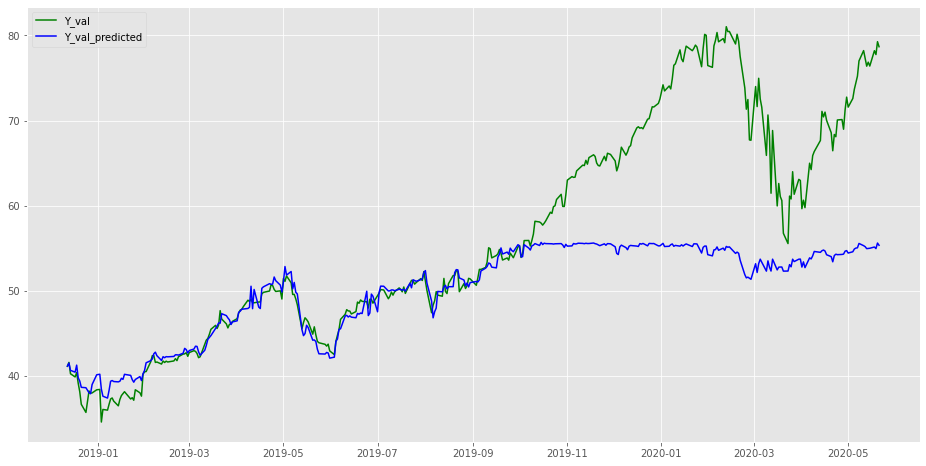

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_rand.iloc[:,0], 'g-', label='Y_val')
plt.plot(y_rand.iloc[:,1], 'b-', label='Y_val_predicted')
plt.legend()

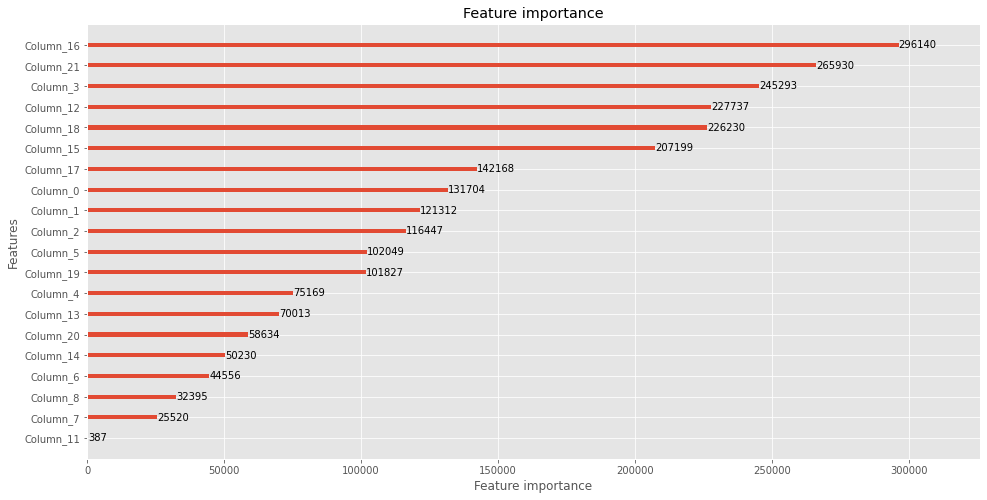

In [ ]:
from lightgbm import plot_importance

fig , ax = plt.subplots(figsize=(16,8))
plot_importance(model_lgbm,ax=ax)

In [ ]:
tt[2].iloc[:,[15,12,3,6,16,21,18,17,0,1,2]]

,MACD,RSI,Volume,SMA_Close_80,macd_signal,ADX,OBV,ATR,High,Low,Open
2018-12-12,-2.165604,33.522888,189126800.0,50.732526,-2.175857,40.996084,4.134545e+10,1.818065,42.947498,41.750000,42.915001
2018-12-13,-2.085288,36.048725,142510800.0,50.599376,-2.157744,41.115069,4.148796e+10,1.784535,42.980000,42.255001,42.599998
2018-12-14,-2.104813,32.158057,127594400.0,50.450857,-2.147158,41.069632,4.136036e+10,1.748399,43.142502,42.387501,42.622501
2018-12-17,-2.126027,31.139108,162814800.0,50.297622,-2.142931,41.442708,4.119755e+10,1.732516,42.270000,41.320000,42.250000
2018-12-18,-2.077060,34.242624,177151600.0,50.149534,-2.129757,42.015875,4.137470e+10,1.800348,42.087502,40.682499,41.362499
...,...,...,...,...,...,...,...,...,...,...,...
2020-05-15,2.598725,62.241218,158929200.0,71.115424,2.323268,27.704097,4.504987e+10,1.971634,77.447502,75.382500,76.127502
2020-05-18,2.655420,65.948789,166348400.0,71.107185,2.389698,27.661005,4.521622e+10,2.026992,76.974998,75.052498,75.087502
2020-05-19,2.633523,64.243417,135178400.0,71.096137,2.438463,28.332491,4.508104e+10,1.961250,79.125000,77.580002,78.292503
2020-05-20,2.706997,67.291340,101729600.0,71.132901,2.492170,29.106204,4.518277e+10,1.991533,79.629997,78.252502,78.757500


In [ ]:
tt[2].iloc[:,[5,19,13,4,20,6,14,8,7,11]]

,SMA_Close_50,BB_upper,macd_fast,SMA_Close_20,BB_lower,SMA_Close_80,macd_slow,SMA_Close_200,SMA_Close_100,totalRevenue
2018-12-12,48.973104,48.611279,42.615512,43.520489,38.429698,50.732526,44.781116,47.045623,50.413682,629000.0
2018-12-13,48.693020,48.316383,42.461034,43.261498,38.206613,50.599376,44.546322,47.039233,50.366639,629000.0
2018-12-14,48.372772,47.997168,42.125480,43.002020,38.006872,50.450857,44.230294,47.029941,50.302921,629000.0
2018-12-17,48.064819,47.570543,41.783881,42.667693,37.764843,50.297622,43.909908,47.017318,50.231056,629000.0
2018-12-18,47.785186,47.111306,41.574599,42.333487,37.555668,50.149534,43.651659,47.006553,50.165850,629000.0
...,...,...,...,...,...,...,...,...,...,...
2020-05-15,67.663376,78.154309,75.089192,72.728362,67.302415,71.115424,72.490467,65.032268,71.868462,575560.0
2020-05-18,67.796034,78.611840,75.569777,73.209838,67.807836,71.107185,72.914358,65.167591,71.948913,575560.0
2020-05-19,68.032880,79.192707,75.906895,73.774713,68.356719,71.096137,73.273371,65.306066,72.024177,575560.0
2020-05-20,68.205022,79.757473,76.424811,74.319485,68.881496,71.132901,73.717814,65.465206,72.100630,575560.0


## $\textbf{XGBoost}$

In [ ]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(n_estimators=100000,
                         learning_rate=0.01,
                         max_depth=5
                         )
model_xgb.fit(tt[0], np.ravel(y_train))

[15:56:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
y_predic_xgb = model_xgb.predict(tt[2])
print('Train MSE :', mean_squared_error(np.ravel(y_train), grid_svr.predict(tt[0])))
print('Val MSE :', mean_squared_error(np.ravel(y_val), y_predic_xgb))

Train MSE : 2.149251146754527e+17
Val MSE : 109.99778759370407


## $\textbf{Catboost}$

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor

     |████████████████████████████████| 67.3MB 54kB/s 


In [ ]:
model_cat = CatBoostRegressor(iterations=100000,
                              learning_rate =0.01,
                              )
model_cat.fit(tt[0], np.ravel(y_train))

Streaming output truncated to the last 5000 lines.
95000:	learn: 0.0001425	total: 10m 59s	remaining: 34.7s
95001:	learn: 0.0001425	total: 10m 59s	remaining: 34.7s
95002:	learn: 0.0001424	total: 10m 59s	remaining: 34.7s
95003:	learn: 0.0001424	total: 10m 59s	remaining: 34.7s
95004:	learn: 0.0001424	total: 10m 59s	remaining: 34.7s
95005:	learn: 0.0001424	total: 10m 59s	remaining: 34.7s
95006:	learn: 0.0001424	total: 10m 59s	remaining: 34.7s
95007:	learn: 0.0001424	total: 10m 59s	remaining: 34.7s
95008:	learn: 0.0001424	total: 10m 59s	remaining: 34.7s
95009:	learn: 0.0001424	total: 10m 59s	remaining: 34.7s
95010:	learn: 0.0001424	total: 10m 59s	remaining: 34.6s
95011:	learn: 0.0001424	total: 10m 59s	remaining: 34.6s
95012:	learn: 0.0001424	total: 10m 59s	remaining: 34.6s
95013:	learn: 0.0001424	total: 10m 59s	remaining: 34.6s
95014:	learn: 0.0001424	total: 10m 59s	remaining: 34.6s
95015:	learn: 0.0001424	total: 10m 59s	remaining: 34.6s
95016:	learn: 0.0001423	total: 10m 59s	remaining: 34.

In [ ]:
y_predic_cat = model_cat.predict(tt[2])
print('Train MSE :', mean_squared_error(np.ravel(y_train), grid_svr.predict(tt[0])))
print('Val MSE :', mean_squared_error(np.ravel(y_val), y_predic_cat))

Train MSE : 2.149251146754527e+17
Val MSE : 128.84037689565142


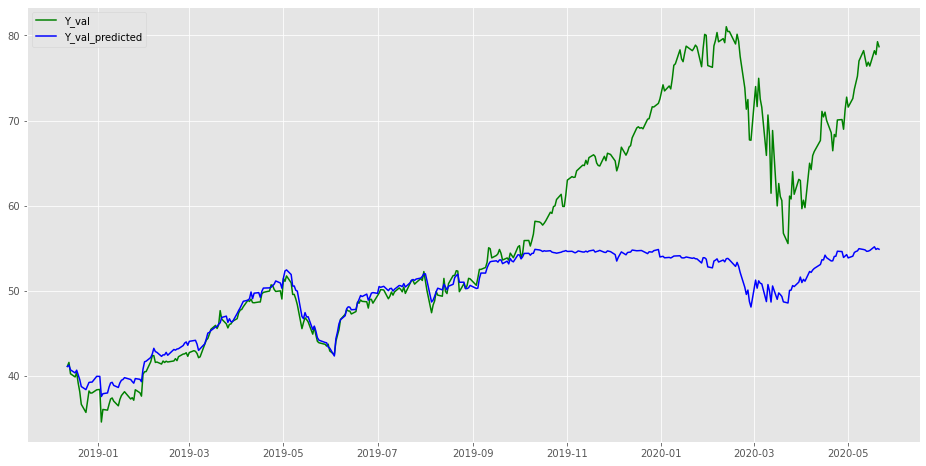

In [ ]:
y_rand_cat = y_val.copy(True)
y_rand_cat['y_val_predicted'] = y_predic_cat
y_rand_cat

plt.figure(figsize=(16,8))
plt.plot(y_rand_cat.iloc[:,0], 'g-', label='Y_val')
plt.plot(y_rand_cat.iloc[:,1], 'b-', label='Y_val_predicted')
plt.legend()

## $\textbf{LSTM}$

In [ ]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_val = X_val.reshape((X_val.shape[0],X_val.shape[1],1))
X_test  = X_test.reshape((X_test.shape[0],X_test.shape[1],1))



In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM


model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)  ))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=200,batch_size=32)



In [ ]:
y_predic_lstm = model.predict(X_val)


print('Train MSE :', mean_squared_error(np.ravel(y_train), model.predict(X_train)))
print('Val MSE :', mean_squared_error(np.ravel(y_val), y_predic_lstm))
print('Test MSE :', mean_squared_error(np.ravel(y_test),model.predict(X_test)))

Train MSE : 0.652454367598534
Val MSE : 133.35669048314577
Test MSE : 4198.182667781085


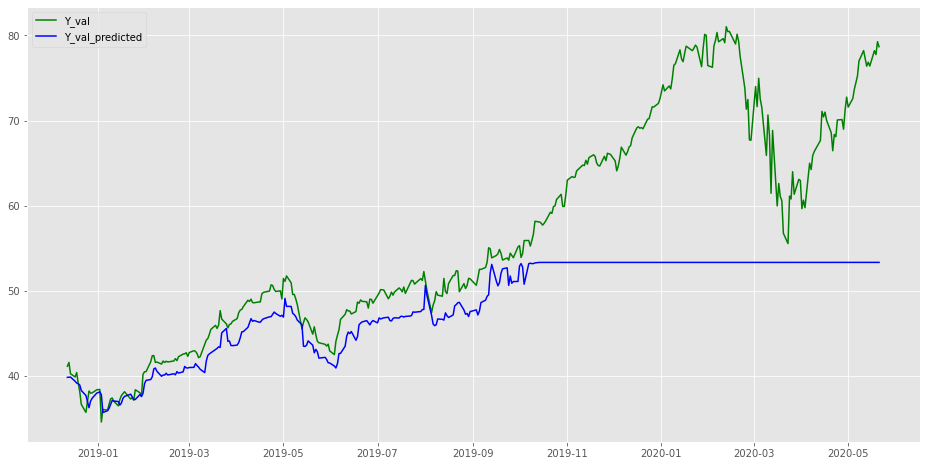

In [ ]:
y_rand_lstm = y_val.copy(True)
y_rand_lstm['y_val_predicted'] = y_predic_lstm
y_rand_lstm.rename(columns={'Adj Close' : 'y_val'}, inplace=True)

plt.figure(figsize=(16,8))
plt.plot(y_rand_lstm.iloc[:,0], 'g-', label='Y_val')
plt.plot(y_rand_lstm.iloc[:,1], 'b-', label='Y_val_predicted')
plt.legend()

In [ ]:
y_rand_lstm.head

<bound method NDFrame.head of                 y_val  y_val_predicted
2018-12-12  41.161091        39.857296
2018-12-13  41.611404        39.868935
2018-12-14  40.279934        39.893234
2018-12-17  39.905083        39.395149
2018-12-18  40.423550        39.189377
...               ...              ...
2020-05-15  76.412621        53.355942
2020-05-18  78.212997        53.355907
2020-05-19  77.761040        53.356071
2020-05-20  79.273354        53.356110
2020-05-21  78.682327        53.356133

[363 rows x 2 columns]>